# Melbourne Beach Surf Forecast

Author: Pedro H. Batista de Moura

Date: April 21, 2024

---


## 1. Goals of the Study

The objective of this project is to utilize unsupervised learning to cluster surf conditions at Melbourne Beach based on comprehensive environmental data, including but not limited to wave height, wave direction, wave period, and wind parameters. This project aims to uncover distinct patterns in surf conditions, ultimately providing insights that can improve surf forecasting and understanding for local surfers.

## 2. Data Source Cleaning/Preprocessing

The data source I'll be using **for** this project will be historical surf and weather data obtained from [Open-Meteo](https://open-meteo.com/).

It contains detailed information on wave and wind conditions specific to Melbourne Beach, features such as wave height, direction, period, wind speed, and others relevant features.


In [41]:
import pandas as pd

# load the data
file_path = '/content/open-meteo-melbourne-beach-22-to-24.xlsx'
data = pd.read_excel(file_path)

# basic look of data
data_info = data.info()
data_head = data.head()

print(data_info, data_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12504 entries, 0 to 12503
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        12504 non-null  datetime64[ns]
 1   wave_height (m)             12504 non-null  float64       
 2   wave_direction (°)          12504 non-null  int64         
 3   wave_period (s)             12504 non-null  float64       
 4   wind_wave_height (m)        12504 non-null  float64       
 5   wind_wave_direction (°)     12504 non-null  int64         
 6   wind_wave_period (s)        12504 non-null  float64       
 7   wind_wave_peak_period (s)   12504 non-null  float64       
 8   swell_wave_height (m)       12504 non-null  float64       
 9   swell_wave_direction (°)    12504 non-null  int64         
 10  swell_wave_period (s)       12504 non-null  float64       
 11  swell_wave_peak_period (s)  12504 non-null  float64   

So, we can see that the dataset has 12,504 entries and 12 columns. Luckily, there are no missing values in any of the columns, making the initial cleaning process "smooth".

The columns include:

* **time:** The date and time of the observation (datetime).

* **wave_height (m):** Height of the wave in meters (float).

* **wave_direction (°):** Direction of the wave in degrees (integer).

* **wave_period (s):** Period of the wave in seconds (float).

* **wind_wave_height (m):** Height of the wind wave in meters (float).

* **wind_wave_direction (°):** Direction of the wind wave in degrees (integer).

* **wind_wave_period (s):** Period of the wind wave in seconds (float).

* **wind_wave_peak_period (s):** Peak period of the wind wave in seconds (float).

* **swell_wave_height (m):** Height of the swell wave in meters (float).

* **swell_wave_direction (°):** Direction of the swell wave in degrees (integer).

* **swell_wave_period (s):** Period of the swell wave in seconds (float).

* **swell_wave_peak_period (s):** Peak period of the swell wave in seconds (float).

### 2.1 Standardize Data

The features was standardized so they have a mean of 0 and a standard deviation of 1. This is a important step because it allow us to use clustering algorithms like K-means, which rely on distance measures.

In [42]:
from sklearn.preprocessing import StandardScaler

# drops the 'time' column
time_col = data.drop(columns='time')

# init the StandardScaler
scaler = StandardScaler()

# standardize all numerical columns
data_scaled = scaler.fit_transform(time_col)
data_scaled = pd.DataFrame(data_scaled, columns=time_col.columns)

data_scaled.head()

,wave_height (m),wave_direction (°),wave_period (s),wind_wave_height (m),wind_wave_direction (°),wind_wave_period (s),wind_wave_peak_period (s),swell_wave_height (m),swell_wave_direction (°),swell_wave_period (s),swell_wave_peak_period (s)
0,-0.487472,0.268319,-0.210492,-0.188819,-0.530355,-0.094061,-0.041899,-0.481254,0.653576,-0.174101,-0.086131
1,-0.487472,0.287477,-0.270299,-0.144625,-0.475404,-0.014263,0.022593,-0.481254,0.653576,-0.174101,-0.086131
2,-0.450082,0.287477,-0.300202,-0.144625,-0.431443,0.025636,0.119332,-0.433413,0.653576,-0.174101,-0.086131
3,-0.450082,0.306635,-0.360009,-0.100431,-0.376492,0.065535,0.151578,-0.433413,0.653576,-0.236985,-0.086131
4,-0.412691,0.325792,-0.449718,-0.100431,-0.310550,0.065535,0.183824,-0.385573,0.686109,-0.362752,-0.086131


### 2.2 Temporal Features (Parse Dates/Times in usable ways)

Now, we have two additionaly temporal features that were extracted from the time column:

* **hour:** The hour of the day (0-23).

* **day_of_week:** The day of the week (0=Monday, 6=Sunday).

In [43]:
# extract additional temporal featues from the 'time' col
data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek  # monday=0, sunday=6

data[['time', 'hour', 'day_of_week']].head()

,time,hour,day_of_week
0,2022-07-30 00:00:00,0,5
1,2022-07-30 01:00:00,1,5
2,2022-07-30 02:00:00,2,5
3,2022-07-30 03:00:00,3,5
4,2022-07-30 04:00:00,4,5


### 2.3 Dimensionality Reduction

First, lets shrink dataset's dimensionality before applying clustering techniques. Principal Component Analysis (PCA) should help improve performance by getting rid of noise and redundancy.

In [44]:
from sklearn.decomposition import PCA

pca = PCA(0.9)
data_reduced = pca.fit_transform(data_scaled)

print("Dimensions before PCA  : {}".format(data_scaled.shape))
print("Dimensions after PCA  : {}".format(data_reduced.shape))


Dimensions before PCA  : (12504, 11)
Dimensions after PCA  : (12504, 5)


## 3. Clustering Techniques

For this project, I will be using two different clustering techniques, K-means Clustering and Hierarchical Clustering





### 3.1 K-means Clustering

Idealy, K-means puts surf conditions into groups based on commonalities in data. It can potentially find patterns, and ideal conditions for surfing at Melbourne Beach.


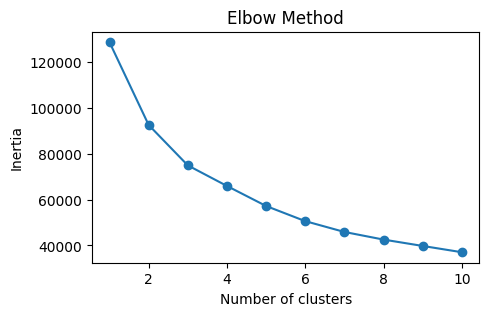

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

range_clusters = range(1, 11)
inertia = []

for k in range_clusters:
    kmeans = KMeans(n_init=10, n_clusters=k, random_state=0)
    kmeans.fit(data_reduced)
    inertia.append(kmeans.inertia_)

# plot the elbow curve
plt.figure(figsize=(5, 3))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


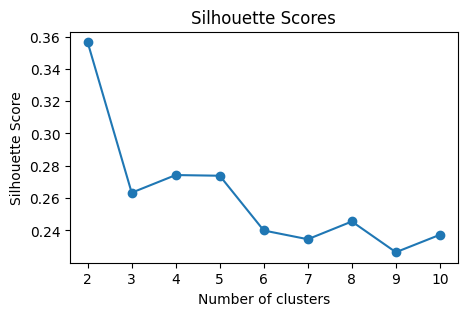

In [46]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

# calculate silhouette scores
for k in range(2, 11):
    kmeans = KMeans(n_init=10, n_clusters=k, random_state=0)
    kmeans.fit(data_reduced)
    score = silhouette_score(data_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# plot the silhouette scores
plt.figure(figsize=(5, 3))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [47]:
optimal_clusters = 2

final_kmeans = KMeans(n_init=10, n_clusters=optimal_clusters, random_state=0)
final_kmeans.fit(data_reduced)

# --------- Exam centroid ---------- #
centroids = final_kmeans.cluster_centers_
for i, centroid in enumerate(centroids):
    print(f"Centroid {i}: {centroid}")

centroids_original_features = pca.inverse_transform(centroids)
for i, centroid in enumerate(centroids_original_features):
    print(f"Centroid {i} in original space: {centroid}")


cluster_labels = kmeans.labels_
data['cluster_label'] = cluster_labels


Centroid 0: [-0.99623764 -0.09671764 -0.00695386 -0.01743563  0.01652252]
Centroid 1: [ 2.87238208  0.27885919  0.02004957  0.05027092 -0.04763821]
Centroid 0 in original space: [-0.43060848  0.13790497 -0.25661577 -0.32817601  0.1197031  -0.33122211
 -0.33032843 -0.40163358  0.21666712 -0.36270753 -0.22696207]
Centroid 1 in original space: [ 1.24154319 -0.39761173  0.73988225  0.94620687 -0.34513155  0.95498948
  0.95241278  1.15800192 -0.62470111  1.04576917  0.65438382]


The values in the original feature space for Centroid 1 are generally higher than those for Centroid 0. This could indicate that Centroid 1 represents conditions with higher wave heights, longer periods, and possibly stronger wind conditions compared to Centroid 0.
The negative values associated with Centroid 0 could be interpreted as representing calmer surf conditions.

**Cluster 0 could represent typical or average surf conditions at Melbourne Beach.
Cluster 1 might represent more extreme surf conditions, which may occur less frequently but are important to recognize for safety and for surfers seeking more challenging waves.**

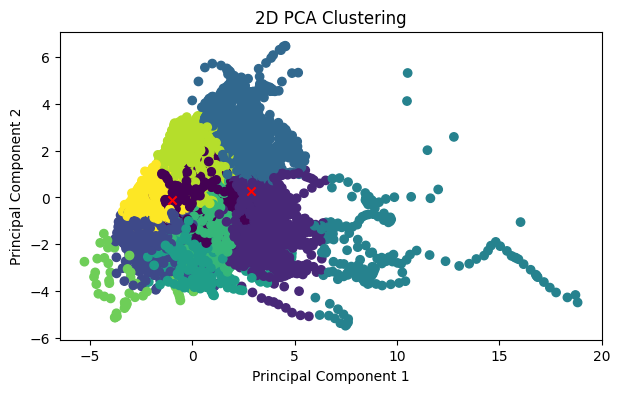

In [65]:
plt.figure(figsize=(7, 4))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')  # centroids
plt.title('2D PCA Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We can see that the scatter plot of the PCA-reduced data with K-means clustering shows two different clusters.
The red 'x' marks represent the centroids of the clusters in the PCA-transformed space.
It seems that the two clusters have some overlap, which might suggest mixed conditions - or maybe even a transitional area where the surf conditions are not that different but still distinguishable.

### 3.2 Hierarchical Clustering

Hierarchical Clustering is just an alternative to K-means. It is used to build cluster trees, understand the structure of data, and see how different surf conditions relate to each other.

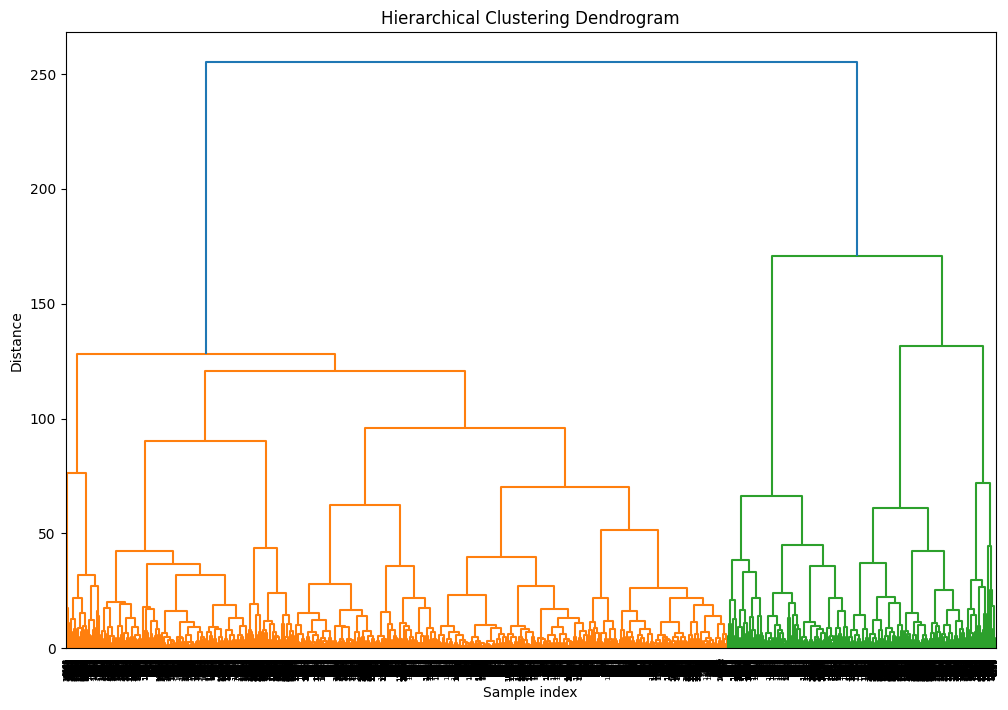

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(data_reduced, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [59]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 250 # based on the dendrogram plot
hierarchical_clusters = fcluster(Z, distance_threshold, criterion='distance')


## Comparing K-Means vs Hierarchical Clustering


### 4.1 Label the data

Add the cluster labels from both models to the original dataset

In [60]:
data['kmeans_cluster'] = kmeans.labels_  # from the earlier K-means model
data['hierarchical_cluster'] = hierarchical_clusters

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12504 entries, 0 to 12503
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        12504 non-null  datetime64[ns]
 1   wave_height (m)             12504 non-null  float64       
 2   wave_direction (°)          12504 non-null  int64         
 3   wave_period (s)             12504 non-null  float64       
 4   wind_wave_height (m)        12504 non-null  float64       
 5   wind_wave_direction (°)     12504 non-null  int64         
 6   wind_wave_period (s)        12504 non-null  float64       
 7   wind_wave_peak_period (s)   12504 non-null  float64       
 8   swell_wave_height (m)       12504 non-null  float64       
 9   swell_wave_direction (°)    12504 non-null  int64         
 10  swell_wave_period (s)       12504 non-null  float64       
 11  swell_wave_peak_period (s)  12504 non-null  float64   

### 4.2 Calculate Comparison Metrics

In [61]:
from sklearn.metrics import adjusted_rand_score, mutual_info_score

rand_index = adjusted_rand_score(data['kmeans_cluster'], data['hierarchical_cluster'])

mutual_info = mutual_info_score(data['kmeans_cluster'], data['hierarchical_cluster'])

print(f"adjusted rand index: {rand_index}")
print(f"mutual information: {mutual_info}")

adjusted rand index: 0.14197527674759203
mutual information: 0.34857063657632625


**Adjusted Rand Index:** the result suggest that the two clustering methods are somewhat consistent with each other, but at the same time they also have some differences in how they group the data points.

**Mutual Information:** Even though the result is not as high as it could possibly be (which would suggest a perfect agreement), it isn't that close to 0 either. So, we could say that the clusterings are not independent.

### 4.3 Visual Comparison

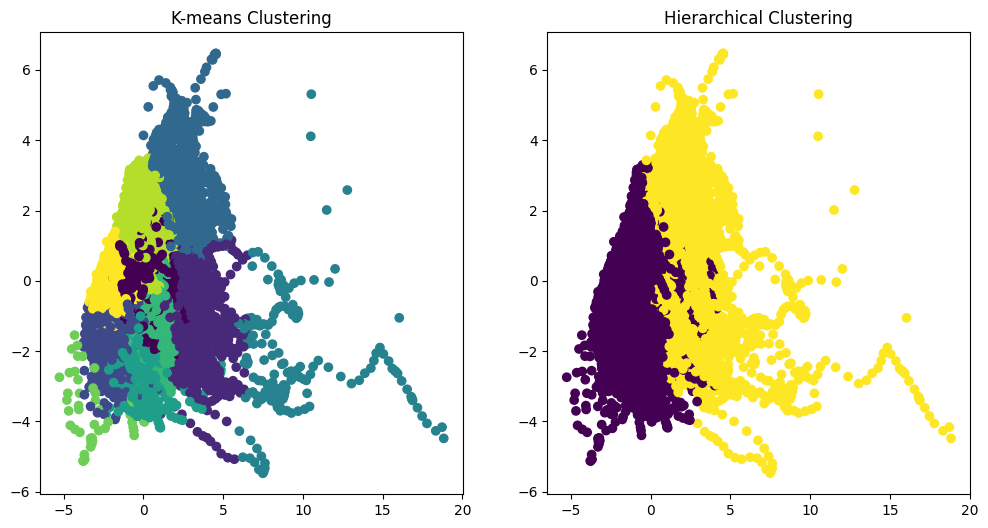

In [62]:
import matplotlib.pyplot as plt

# k-means clusters plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=data['kmeans_cluster'], cmap='viridis')
plt.title('K-means Clustering')

# hierarchical clusters plot
plt.subplot(1, 2, 2)
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=data['hierarchical_cluster'], cmap='viridis')
plt.title('Hierarchical Clustering')

plt.show()


Ideally, K-means may be better for clear, distinct categories of surf conditions. On the other hand, Hierarchical might offer a more nuanced understanding that could possibly captures gradual transitions in surf conditions.